In [1]:
import nltk
nltk.download('stopwords')

# gerais
import re
import numpy as np
import pandas as pd
from pprint import pprint


# Gensim
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


#plot
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


[nltk_data] Downloading package stopwords to /home/renato/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("portuguese"))
stop_words.update(['que', 'até', 'esse', 
                    'essa', 'pro', 'pra',
                    'oi', 'lá', 'blá', 'dos'])

In [3]:
# Import Dataset
df = pd.read_csv('../Dados coletados/Twitter_padronizado.csv', encoding='utf-8',  lineterminator='\n')
df.head()

,Unnamed: 0,ID,USUARIO,TWEET,DATA_TWEET,language
0,1,2,meliiuza,RT @joshfeelsz: Meu Deus Eu tô em loop com ess...,2020-09-22 14:17:14,portuguese
1,9,11,Karine77379754,RT @majorjhs: eu nem fico mais surpresa com a ...,2020-09-22 14:17:19,portuguese
2,19,22,EloaSuzi,RT @fabiofaria5555: PR @jairbolsonaro discursa...,2020-09-22 14:17:23,portuguese
3,21,24,Djan00392004,RT @planalto: #AoVivo: Presidente @jairbolsona...,2020-09-22 14:17:22,portuguese
4,22,25,barbaralustoza,biroliro falando de cristofobia na Assembleia ...,2020-09-22 14:17:22,portuguese


## Pré processamento

In [6]:
def remove_elementos_repetidos(lista):
    nova_lista = []
    for item in lista:
        if item not in nova_lista:
            nova_lista.append(item)
    return nova_lista

# remove special characters and digits
def clean_tweet(tweet):
    # remove os RT
    tweet = re.sub(r'RT+', '', tweet) 
    
    # remove as menções
    tweet = re.sub(r'@\S+', '', tweet)  
    
    # remove links e alguns pontos
    tweet = re.sub(r'kkk\S+', '', tweet)
    tweet = re.sub(r"http\S+", "", tweet).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    
    # remove alguns caracteres
    tweet  = re.sub("(\\d|\\W)+|\w*\d\w*"," ",tweet )
    tweet = ' '.join(s for s in tweet.split() if (not any(c.isdigit() for c in s)) and len(s) > 2)
    tweet = tweet.replace("\n", "")
    return tweet

In [7]:
clean_tweets = []
for w in range(len(df.TWEET)):
  tweet = df['TWEET'].iloc[w]
  tweet = clean_tweet(tweet)
    
  clean_tweets.append(tweet)

#remover colunas repetidas
clean_tweets = remove_elementos_repetidos(clean_tweets)
clean_tweets[1:10]

['nem fico mais surpresa com forma que essas premiações americanas tratam bts eles são maiores artistas geração',
 'discursa agora assembleia geral organização das nações unidas onu brasil segue mostran',
 'aovivo presidente faz discurso abertura assembleia geral organização das nações unidas onu',
 'biroliro falando cristofobia assembleia geral onu claro igrejas cristãs são invadidas destruídas todos',
 'discurso bolsonaro assembleia geral onu foi sucessão vergonhosa mentiras não restam dúvidas que ele',
 'luto preço ser alfabetizado ouvir esse discurso bolsonaro assembleia geral onu saber que ele pres',
 'bts participarar mais uma vez assembleia geral das nações unidas dia setembro grupo compartilhará uma men',
 'que pesadelo presidente brasil enfileirando mentiras narrativas sem nem cabeça preconceitos teorias conspi',
 'para quem não paraná não sabe que migué dolangue bolsonaro falando assembléia geral onu que']

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(clean_tweets))

print(data_words[:10])

[['meu', 'deus', 'loop', 'com', 'esse', 'negocio', 'overthemoon'], ['nem', 'fico', 'mais', 'surpresa', 'com', 'forma', 'que', 'essas', 'premiacoes', 'americanas', 'tratam', 'bts', 'eles', 'sao', 'maiores', 'artistas', 'geracao'], ['discursa', 'agora', 'assembleia', 'geral', 'organizacao', 'das', 'nacoes', 'unidas', 'onu', 'brasil', 'segue', 'mostran'], ['aovivo', 'presidente', 'faz', 'discurso', 'abertura', 'assembleia', 'geral', 'organizacao', 'das', 'nacoes', 'unidas', 'onu'], ['biroliro', 'falando', 'cristofobia', 'assembleia', 'geral', 'onu', 'claro', 'igrejas', 'cristas', 'sao', 'invadidas', 'destruidas', 'todos'], ['discurso', 'bolsonaro', 'assembleia', 'geral', 'onu', 'foi', 'sucessao', 'vergonhosa', 'mentiras', 'nao', 'restam', 'duvidas', 'que', 'ele'], ['luto', 'preco', 'ser', 'alfabetizado', 'ouvir', 'esse', 'discurso', 'bolsonaro', 'assembleia', 'geral', 'onu', 'saber', 'que', 'ele', 'pres'], ['bts', 'participarar', 'mais', 'uma', 'vez', 'assembleia', 'geral', 'das', 'nacoes

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['meu', 'deus', 'loop', 'com', 'esse', 'negocio', 'overthemoon']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]



In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])


In [12]:
data_words = data_words_bigrams
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1)]]


100%|██████████| 8/8 [04:00<00:00, 30.12s/it]


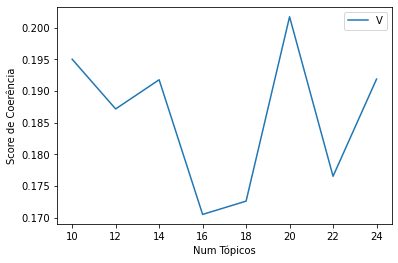

A quantidade de tópicos = 10  tem um valor de coerência de  0.195
A quantidade de tópicos = 12  tem um valor de coerência de  0.1872
A quantidade de tópicos = 14  tem um valor de coerência de  0.1918
A quantidade de tópicos = 16  tem um valor de coerência de  0.1705
A quantidade de tópicos = 18  tem um valor de coerência de  0.1726
A quantidade de tópicos = 20  tem um valor de coerência de  0.2017
A quantidade de tópicos = 22  tem um valor de coerência de  0.1766
A quantidade de tópicos = 24  tem um valor de coerência de  0.1919


In [14]:
from tqdm import tqdm
from gensim.models.ldamulticore import LdaMulticore
# Função para determinar a melhor quantidade de tópicos para a modelagem
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, 
                                        dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Colocando parametros na função
model_list, coherence_values =  compute_coherence_values(dictionary=id2word, corpus=corpus, 
                         texts=data_words, start=10, limit=25, step=2)

# Mostrando visualmente a quantidade de tópicos
limit=25; start=10; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico
for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

In [15]:
# Vamos agora construir de fato o modelo 
LDAlda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=30, 
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True,
                        alpha = 0.9,
                        eta = 0.3)

In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('deus', 1), ('loop', 1), ('negocio', 1), ('overthemoon', 1)]]

In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


KeyboardInterrupt: 

In [16]:
optimal_model = model_list[0]
optimal_model.print_topics(num_topics = 30, num_words = 20)

[(0,
  '0.036*"nao" + 0.012*"ser" + 0.009*"vai" + 0.008*"jogo" + 0.007*"voce" + 0.007*"deus" + 0.006*"foto" + 0.006*"pode" + 0.005*"botafogo" + 0.005*"time" + 0.005*"vou" + 0.005*"ate" + 0.005*"cara" + 0.005*"bolsonaro" + 0.004*"ver" + 0.004*"quero" + 0.004*"agora" + 0.004*"melhor" + 0.004*"nada" + 0.003*"tao"'),
 (1,
  '0.047*"nao" + 0.009*"melhor" + 0.009*"sempre" + 0.009*"sao" + 0.008*"sim" + 0.008*"gosto" + 0.008*"reinaldo" + 0.006*"shawn" + 0.005*"ser" + 0.005*"aqui" + 0.005*"trends" + 0.004*"mim" + 0.004*"falar" + 0.004*"brasil" + 0.004*"demais" + 0.004*"gente" + 0.004*"amo" + 0.003*"musica" + 0.003*"idoso" + 0.003*"cara"'),
 (2,
  '0.018*"nao" + 0.017*"sao" + 0.012*"paulo" + 0.008*"encontro" + 0.006*"bolsonaro" + 0.005*"dia" + 0.005*"diniz" + 0.005*"melhor" + 0.005*"stf" + 0.004*"anos" + 0.004*"cara" + 0.004*"idoso" + 0.004*"bom" + 0.004*"agora" + 0.004*"river" + 0.004*"flay" + 0.004*"tinga" + 0.003*"ter" + 0.003*"personagem" + 0.003*"bem"'),
 (3,
  '0.039*"dia" + 0.027*"nao" + 